<a href="https://colab.research.google.com/github/adityasaxena-crypto/emotion-sentiment-based-chabot/blob/main/Chatbot_research2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import io
import nltk
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM , Dense,GlobalAveragePooling1D,Flatten, Dropout , GRU
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv1D, MaxPool1D

In [12]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [13]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.4147413220000544
GPU (s):
0.0877434029999904
GPU speedup over CPU: 38x


In [85]:
!pip install transformers -q

     |████████████████████████████████| 4.9 MB 4.8 MB/s 
     |████████████████████████████████| 6.6 MB 43.4 MB/s 
     |████████████████████████████████| 163 kB 57.7 MB/s 


In [86]:
from transformers import pipeline
emotion = pipeline('sentiment-analysis', model='arpanghoshal/EmoRoBERTa')

Downloading:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [58]:
with open("/content/Intent (1).json") as diabetes_dataset:
  dataset = json.load(diabetes_dataset)

In [59]:
def processing_json_dataset(dataset):
  tags = []
  inputs = []
  responses={}
  for intent in dataset['intents']:
    responses[intent['intent']]=intent['responses']
    for lines in intent['text']:
      inputs.append(lines)
      tags.append(intent['intent'])
  return [tags, inputs, responses]

In [60]:
[tags, inputs, responses] = processing_json_dataset(dataset)

In [61]:
dataset = pd.DataFrame({"inputs":inputs,
                     "tags":tags})

In [62]:
dataset = dataset.sample(frac=1)

In [63]:
dataset.head()

,inputs,tags
26,Great thanks! My user is Bella,CourtesyGreetingResponse
120,Make me laugh,Jokes
133,Well why not,PodBayDoorResponse
84,fuck,Swearing
118,How about a joke,Jokes


In [64]:
import string
dataset['inputs'] = dataset['inputs'].apply(lambda sequence:
                                            [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])

In [65]:
dataset['inputs'] = dataset['inputs'].apply(lambda wrd: ''.join(wrd))

In [66]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(dataset['inputs'])
train = tokenizer.texts_to_sequences(dataset['inputs'])
features = pad_sequences(train)
le = LabelEncoder()
labels = le.fit_transform(dataset['tags'])

In [67]:
input_shape = features.shape[1]
print(input_shape)

17


In [68]:
vocabulary = len(tokenizer.word_index)
print("number of unique words",vocabulary)
output_length = le.classes_.shape[0]
print("output length: ",output_length)

number of unique words 140
output length:  23


In [69]:
m = Sequential()
m.add(Input(shape=(features.shape[1])))
m.add(Embedding(vocabulary + 1,100))
m.add(Conv1D(filters=32, kernel_size=5, activation="relu", kernel_initializer=tf.keras.initializers.GlorotNormal(),bias_regularizer=tf.keras.regularizers.L2(0.0001), kernel_regularizer=tf.keras.regularizers.L2(0.0001), activity_regularizer = tf.keras.regularizers.L2(0.0001))) 
m.add(Dropout(0.3))
m.add(LSTM(128, dropout=0.3,return_sequences=True))
m.add(LSTM(32, dropout=0.3,return_sequences=False))
m.add(Dense(16,activation="relu", activity_regularizer = tf.keras.regularizers.L2(0.0001))) 
m.add(Dropout(0.6))
m.add(Dense(output_length, activation="softmax", activity_regularizer = tf.keras.regularizers.L2(0.0001)))

In [26]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2022-10-01 18:07:48--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-10-01 18:07:48--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 38s  

2022-10-01 18:10:27 (5.19 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [27]:
m.layers

In [28]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [70]:
glove_dir = "glove.6B.100d.txt"
embeddings_index = {}
file_ = open(glove_dir)
for line in file_:
    arr = line.split()
    single_word = arr[0]
    w = np.asarray(arr[1:],dtype='float32')
    embeddings_index[single_word] = w
file_.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [71]:
max_words = vocabulary + 1
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words,100)).astype(object)
for word , i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [72]:
m.layers[0].set_weights([embedding_matrix])
m.layers[0].trainable = False

In [32]:
m.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [33]:
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 100)           14100     
                                                                 
 conv1d (Conv1D)             (None, 13, 32)            16032     
                                                                 
 dropout (Dropout)           (None, 13, 32)            0         
                                                                 
 lstm (LSTM)                 (None, 13, 128)           82432     
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0

In [34]:
from keras.callbacks import TensorBoard, EarlyStopping
earlyStopping = EarlyStopping(monitor = 'loss', patience = 400, mode = 'min', restore_best_weights = True)

In [35]:
history_training = m.fit(features,labels,epochs=2000, batch_size=64, callbacks=[ earlyStopping])

Epoch 1/2000
3/3 [==============================] - 6s 38ms/step - loss: 3.1419 - accuracy: 0.0325
Epoch 2/2000
3/3 [==============================] - 0s 10ms/step - loss: 3.1361 - accuracy: 0.0584
Epoch 3/2000
3/3 [==============================] - 0s 11ms/step - loss: 3.1174 - accuracy: 0.0649
Epoch 4/2000
3/3 [==============================] - 0s 11ms/step - loss: 3.1255 - accuracy: 0.0584
Epoch 5/2000
3/3 [==============================] - 0s 10ms/step - loss: 3.1013 - accuracy: 0.0844
Epoch 6/2000
3/3 [==============================] - 0s 9ms/step - loss: 3.1054 - accuracy: 0.0519
Epoch 7/2000
3/3 [==============================] - 0s 8ms/step - loss: 3.1306 - accuracy: 0.0325
Epoch 8/2000
3/3 [==============================] - 0s 11ms/step - loss: 3.0990 - accuracy: 0.0649
Epoch 9/2000
3/3 [==============================] - 0s 11ms/step - loss: 3.0887 - accuracy: 0.0779
Epoch 10/2000
3/3 [==============================] - 0s 10ms/step - loss: 3.0748 - accuracy: 0.0519
Epoch 11/20

In [36]:
import matplotlib as mpl
def draw_plot(data, type_data):
  mpl.style.use('seaborn')
  plt.figure(figsize = (25, 5))
  plt.plot(data,'darkorange', label='Train')
  plt.xlabel('Epoch')
  plt.ylabel(type_data)
  plt.legend()

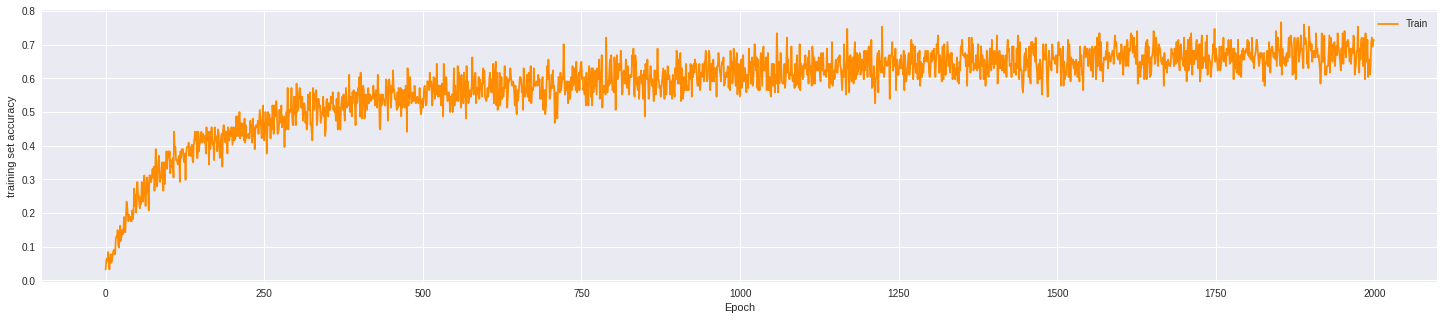

In [37]:
draw_plot(history_training.history['accuracy'],'training set accuracy' )

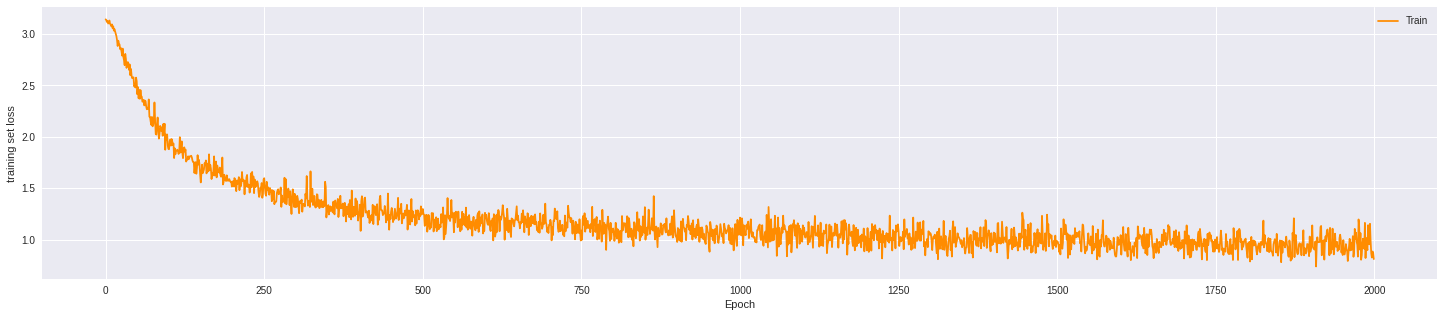

In [38]:
draw_plot(history_training.history['loss'],'training set loss' )

In [39]:
m.evaluate(features, labels, batch_size = 64)

3/3 [==============================] - 1s 9ms/step - loss: 0.1813 - accuracy: 0.9740


[0.18130366504192352, 0.9740259647369385]

In [73]:
m1 = Sequential()
m1.add(Input(shape=(features.shape[1])))
m1.add(Embedding(vocabulary + 1,100))
m1.add(Conv1D(filters=32, kernel_size=5, activation="relu", kernel_initializer=tf.keras.initializers.GlorotNormal(),bias_regularizer=tf.keras.regularizers.L2(0.0001), kernel_regularizer=tf.keras.regularizers.L2(0.0001), activity_regularizer = tf.keras.regularizers.L2(0.0001))) 
m1.add(Dropout(0.3))
m1.add(Dense(32,activation="relu", activity_regularizer = tf.keras.regularizers.L2(0.0001))) 
m1.add(LSTM(512, dropout=0.3,return_sequences=False))
m1.add(Dropout(0.6))
m1.add(Dense(output_length, activation="softmax", activity_regularizer = tf.keras.regularizers.L2(0.0001)))

In [74]:
m1.layers[0].set_weights([embedding_matrix])
m1.layers[0].trainable = False

In [75]:
m1.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [43]:
m1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 17, 100)           14100     
                                                                 
 conv1d_1 (Conv1D)           (None, 13, 32)            16032     
                                                                 
 dropout_2 (Dropout)         (None, 13, 32)            0         
                                                                 
 dense_2 (Dense)             (None, 13, 32)            1056      
                                                                 
 lstm_2 (LSTM)               (None, 512)               1116160   
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 23)               

In [76]:
history_training = m1.fit(features,labels,epochs=2000, batch_size=64, callbacks=[ earlyStopping])

Epoch 1/2000
3/3 [==============================] - 2s 18ms/step - loss: 3.1352 - accuracy: 0.0519
Epoch 2/2000
3/3 [==============================] - 0s 11ms/step - loss: 3.0877 - accuracy: 0.0714
Epoch 3/2000
3/3 [==============================] - 0s 12ms/step - loss: 3.0087 - accuracy: 0.0779
Epoch 4/2000
3/3 [==============================] - 0s 12ms/step - loss: 2.9658 - accuracy: 0.0714
Epoch 5/2000
3/3 [==============================] - 0s 12ms/step - loss: 2.9261 - accuracy: 0.1169
Epoch 6/2000
3/3 [==============================] - 0s 12ms/step - loss: 2.8531 - accuracy: 0.1623
Epoch 7/2000
3/3 [==============================] - 0s 12ms/step - loss: 2.7784 - accuracy: 0.2532
Epoch 8/2000
3/3 [==============================] - 0s 12ms/step - loss: 2.7073 - accuracy: 0.2468
Epoch 9/2000
3/3 [==============================] - 0s 12ms/step - loss: 2.6075 - accuracy: 0.2273
Epoch 10/2000
3/3 [==============================] - 0s 12ms/step - loss: 2.5754 - accuracy: 0.2078
Epoch 11/

In [45]:
import matplotlib as mpl
def draw_plot(data, type_data):
  mpl.style.use('seaborn')
  plt.figure(figsize = (25, 5))
  plt.plot(data,'darkorange', label='Train')
  plt.xlabel('Epoch')
  plt.ylabel(type_data)
  plt.legend()

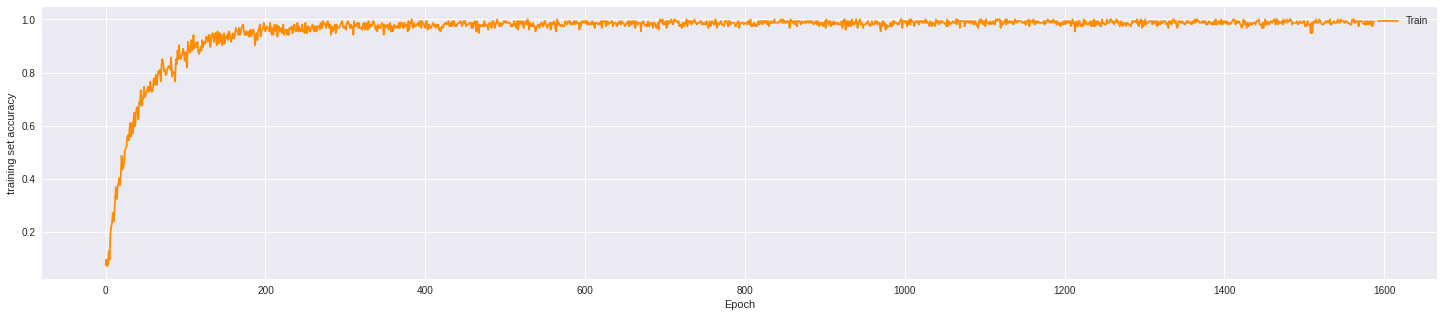

In [46]:
draw_plot(history_training.history['accuracy'],'training set accuracy' )

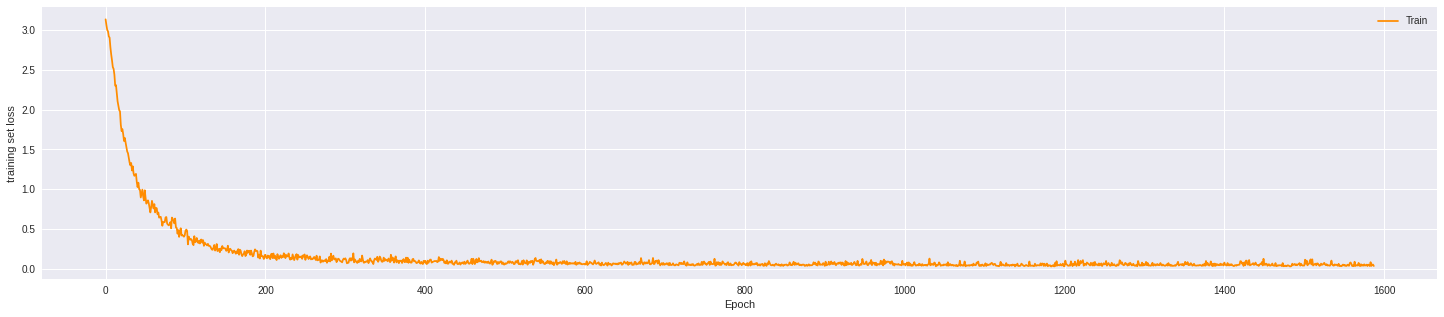

In [47]:
draw_plot(history_training.history['loss'],'training set loss' )

In [77]:
m1.evaluate(features, labels, batch_size = 64)

3/3 [==============================] - 1s 8ms/step - loss: 0.0275 - accuracy: 0.9935


[0.027546260505914688, 0.9935064911842346]

Testing

In [49]:
import random
def generate_answer(query):
  texts = []
  pred_input = query
  pred_input = [letters.lower() for letters in pred_input if letters not in string.punctuation]
  pred_input = ''.join(pred_input)
  texts.append(pred_input)
  pred_input = tokenizer.texts_to_sequences(texts)
  pred_input = np.array(pred_input).reshape(-1)
  pred_input = pad_sequences([pred_input],input_shape)
  output = m.predict(pred_input)
  output = output.argmax()
  response_tag = le.inverse_transform([output])[0]
  return random.choice(responses[response_tag])

In [50]:
list_que = ["hello", "i am kaled","what is my name?",
            "what is your name?", "tell me please, what is your name?"]
for i in list_que:
  print("you: {}".format(i))
  res_tag = generate_answer(i)
  print(res_tag) 

you: hello
Hola human, please tell me your GeniSys user
you: i am kaled
OK! Hola <HUMAN>, how can I help you?
you: what is my name?
You can call me Geni
you: what is your name?
You can call me Geni
you: tell me please, what is your name?
One sec


In [51]:
import random
def generate_answer(query):
  texts = []
  pred_input = query
  pred_input = [letters.lower() for letters in pred_input if letters not in string.punctuation]
  pred_input = ''.join(pred_input)
  texts.append(pred_input)
  pred_input = tokenizer.texts_to_sequences(texts)
  pred_input = np.array(pred_input).reshape(-1)
  pred_input = pad_sequences([pred_input],input_shape)
  output = m1.predict(pred_input)
  output = output.argmax()
  response_tag = le.inverse_transform([output])[0]
  return random.choice(responses[response_tag])

In [83]:
list_que = ["are you deaf?? i said i need the executive or the customer care"]
for i in list_que:
  print("you: {}".format(i))
  res_tag = generate_answer(i)
  print(res_tag) 

you: are you deaf?? i said i need the executive or the customer care
You are being transfered to our customer care section.


In [53]:
list_que = ["hello my name is rishabh", "i am stupid","what is my name?",
            "what is your name?", "tell me please, what is your name i am very sad"]
for i in list_que:
  print("you: {}".format(i))
  res_tag = generate_answer(i)
  print(res_tag) 

you: hello my name is rishabh
Good! Hi <HUMAN>, how can I help you?
you: i am stupid
Good! Hi <HUMAN>, how can I help you?
you: what is my name?
<HUMAN>, what can I do for you?
you: what is your name?
Call me Geni
you: tell me please, what is your name i am very sad
Your name is  <HUMAN>, how can I help you?


In [89]:
list_que = ["are you deaf?? i said i need the executive or the customer care"]
connect_executive = ["anger","confusion"]
for i in list_que:
  emotion_labels = emotion(i)
  dict1 = emotion_labels[0]
  sentiment = dict1['label']
  print(sentiment)
  if sentiment in connect_executive:
    print("Bhai talk to executive please")
  else:
    print("you: {}".format(i))
    res_tag = generate_answer(i)
    print(res_tag) 

neutral
you: are you deaf?? i said i need the executive or the customer care
I apologise for the issue you faced, I am connecting you to our customer care team.


In [90]:
over=True
while(not over):
  list_que=list(input())
  for i in list_que:
  emotion_labels = emotion(i)
  dict1 = emotion_labels[0]
  sentiment = dict1['label']
  print(sentiment)
  if sentiment in connect_executive:
    print("Bhai talk to executive please")
  else:
    print("you: {}".format(i))
    res_tag = generate_answer(i)
    print(res_tag) 

IndentationError: ignored